In [2]:
from pysurvival.datasets import Dataset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
raw_dataset = Dataset('churn').load()

In [4]:
print('The raw dataset has the following shape: {}.'.format(raw_dataset.shape))

The raw dataset has the following shape: (2000, 14).


In [5]:
raw_dataset.head(2)

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0


In [7]:
raw_dataset.product_travel_expense.value_counts()

Free-Trial    1608
Active         374
No              18
Name: product_travel_expense, dtype: int64

In [8]:
raw_dataset.product_payroll.value_counts()

Active        934
Free-Trial    726
No            340
Name: product_payroll, dtype: int64

In [9]:
raw_dataset.product_accounting.value_counts()

Active        1010
No             503
Free-Trial     487
Name: product_accounting, dtype: int64

In [10]:
raw_dataset.company_size.value_counts()

10-50            690
50-100           687
1-10             316
100-250          244
self-employed     63
Name: company_size, dtype: int64

In [11]:
raw_dataset.us_region.value_counts()

Mountain              235
Middle Atlantic       235
New England           234
South Atlantic        225
East South Central    218
West North Central    217
Pacific               217
East North Central    211
West South Central    208
Name: us_region, dtype: int64

In [12]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting', 'company_size', 'us_region']

dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()

In [27]:
# Checking for null values 
n_null = sum(dataset[features].isnull().sum())
print('The dataset contains {} null values'.format(n_null))

# Removing duplicates if there exist
n_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print('The dataset contains {} duplicates'.format(n_dupli))

n = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 0 duplicates


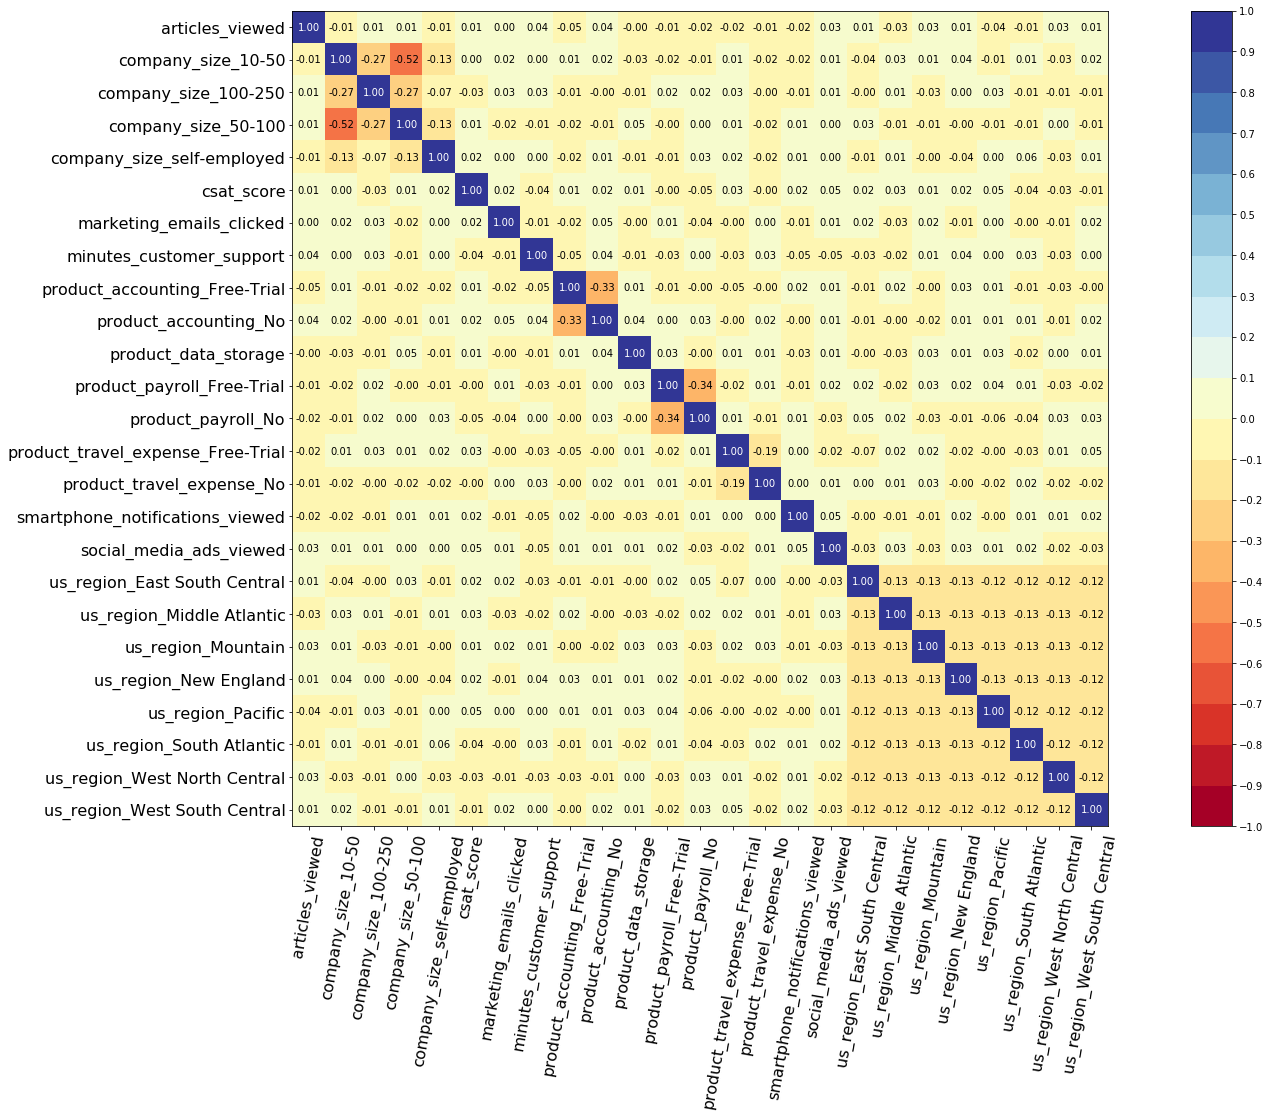

In [29]:
from pysurvival.utils.display import correlation_matrix

correlation_matrix(dataset[features], figure_size=(30, 15), text_fontsize=10)

In [33]:
from sklearn.model_selection import train_test_split

# Building training and testing sets
index_train, index_test = train_test_split(range(n), test_size=0.35)
data_train = dataset.loc[index_train].reset_index(drop=True)
data_test = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs

X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [37]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt', 
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

ConditionalSurvivalForestModel

In [40]:
# Computing variables importance
csf.variable_importance_table.head()

,feature,importance,pct_importance
0,csat_score,13.791813,0.209278
1,product_payroll_No,11.988494,0.181914
2,minutes_customer_support,10.053997,0.152560
3,product_accounting_No,7.627277,0.115737
4,product_travel_expense_Free-Trial,5.897717,0.089492


In [41]:
from pysurvival.utils.metrics import concordance_index

c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.82


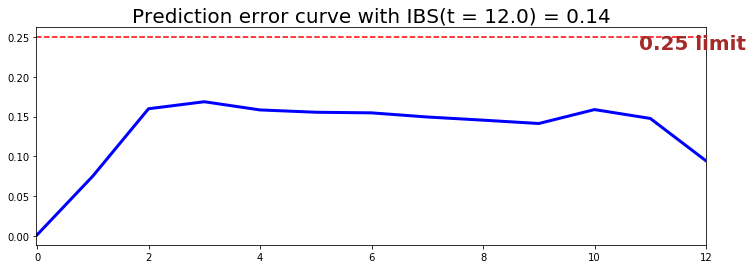

IBS: 0.14


In [44]:
from pysurvival.utils.display import integrated_brier_score

ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12, figure_size=(12, 4))
print('IBS: {:.2f}'.format(ibs))

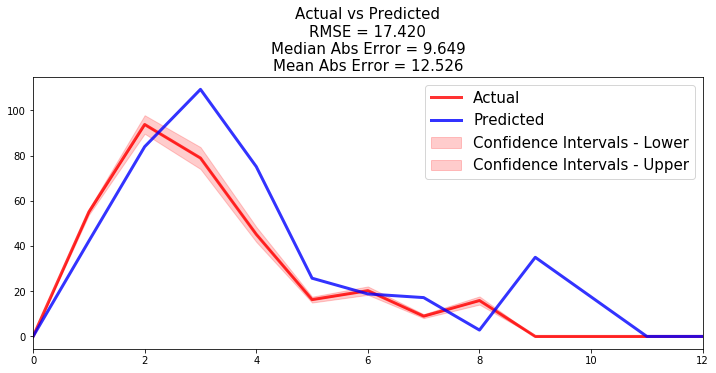

In [45]:
from pysurvival.utils.display import compare_to_actual

results = compare_to_actual(csf, X_test, T_test, E_test, 
                            is_at_risk = False, figure_size=(12, 5), 
                            metrics=['rmse', 'mean', 'median'])

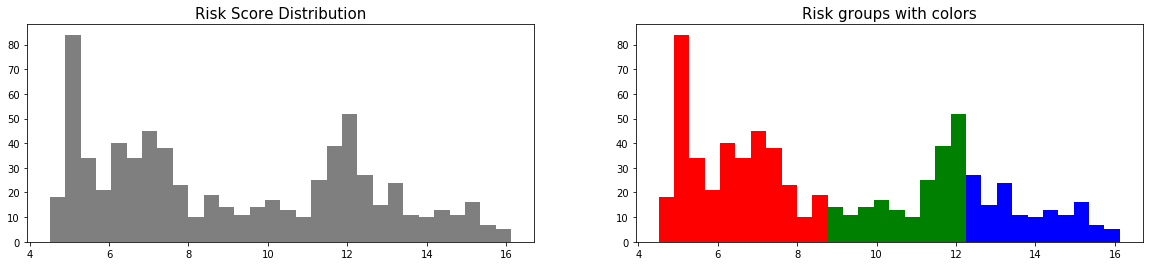

In [46]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test, use_log=False, num_bins=30, 
                                 figure_size=(20, 4), 
                                 low={'lower_bound':0,'upper_bound':8.5, 'color':'red'}, 
                                 medium={'lower_bound':8.5, 'upper_bound':12., 'color':'green'},
                                 high={'lower_bound':12., 'upper_bound':25, 'color':'blue'})

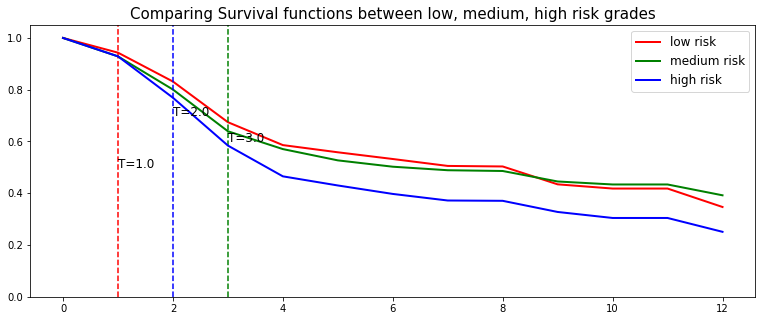

In [54]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(13, 5))

# Selecting a random individual that experienced an event from each group
groups=[]
for i, (label, (color, indexes)) in enumerate(risk_groups.items()):
    if len(indexes) == 0:
        continue
    X=X_test.values[indexes, :]
    T=T_test.values[indexes]
    E=E_test.values[indexes]
    
    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0:
        continue
    k = np.random.choice(choices, 1)[0]
    t = T[k]
    
    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()
    
    # Displaying the functions
    label_='{} risk'.format(label)
    plt.plot(csf.times, survival, color=color, label=label_, lw=2)
    groups.append(label)
    
    # Actual time
    plt.axvline(x=t, color=color, ls='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)), 
               xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)
    
# Show everything
groups_str = ', '.join(groups)
title='Comparing Survival functions between {} risk grades'.format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show();